# Probability to become a premium

We have lunched new section that tells about premium subscription advantage
Treatment - Saw new section
Outcome - Conversion to premium subscription
Our covariate is probability of premium subscription predicted by our ML model.

We will test hypothesis:

$H_o$ - There is no difference in conversion between treatment and control groups.

$H_a$ - There is a difference in conversion between treatment and control groups.

## Data

We will use DGP from Causalis. Read more at https://causalis.causalcraft.com/articles/generate_cuped_binary

In [1]:
from causalis.scenarios.cuped.dgp import make_cuped_binary_26
from causalis.data_contracts import CausalData

data = make_cuped_binary_26(return_causal_data=False, include_oracle=True)
data.head()


,y,d,tenure_months,spend_last_month,discount_rate,support_tickets,email_open_rate,referral_count,plan_tier_plus,plan_tier_pro,region_eu,m,m_obs,tau_link,g0,g1,cate,y_pre
0,0.0,0.0,14.187461,62.867015,0.087395,2.0,0.412214,2.0,0.0,0.0,0.0,0.5,0.5,0.081508,0.267699,0.280682,0.012983,0.009942
1,0.0,0.0,7.242801,112.089626,0.173939,2.0,0.131957,0.0,0.0,0.0,0.0,0.5,0.5,0.037301,0.223180,0.228483,0.005303,-0.220081
2,1.0,1.0,17.729423,16.813523,0.141900,2.0,0.376393,0.0,1.0,0.0,0.0,0.5,0.5,0.060442,0.245717,0.254861,0.009144,0.096021
3,0.0,0.0,19.497424,43.456545,0.146694,2.0,0.680602,1.0,0.0,0.0,0.0,0.5,0.5,0.096195,0.269024,0.284422,0.015398,0.188115
4,0.0,0.0,4.592766,105.987656,0.112326,6.0,0.642113,0.0,1.0,0.0,1.0,0.5,0.5,0.011141,0.264030,0.265771,0.001741,-0.250511


In [2]:
causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months', 'spend_last_month', 'discount_rate', 'support_tickets', 'email_open_rate', 'referral_count', 'plan_tier_plus', 'plan_tier_pro', 'region_eu', 'y_pre'])
causaldata

CausalData(df=(10000, 12), treatment='d', outcome='y', confounders=['tenure_months', 'spend_last_month', 'discount_rate', 'support_tickets', 'email_open_rate', 'referral_count', 'plan_tier_plus', 'plan_tier_pro', 'region_eu', 'y_pre'])

In [3]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,5034,0.276917,0.447520,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1.0,4966,0.298027,0.457437,0.0,0.0,0.0,0.0,1.0,1.0,1.0


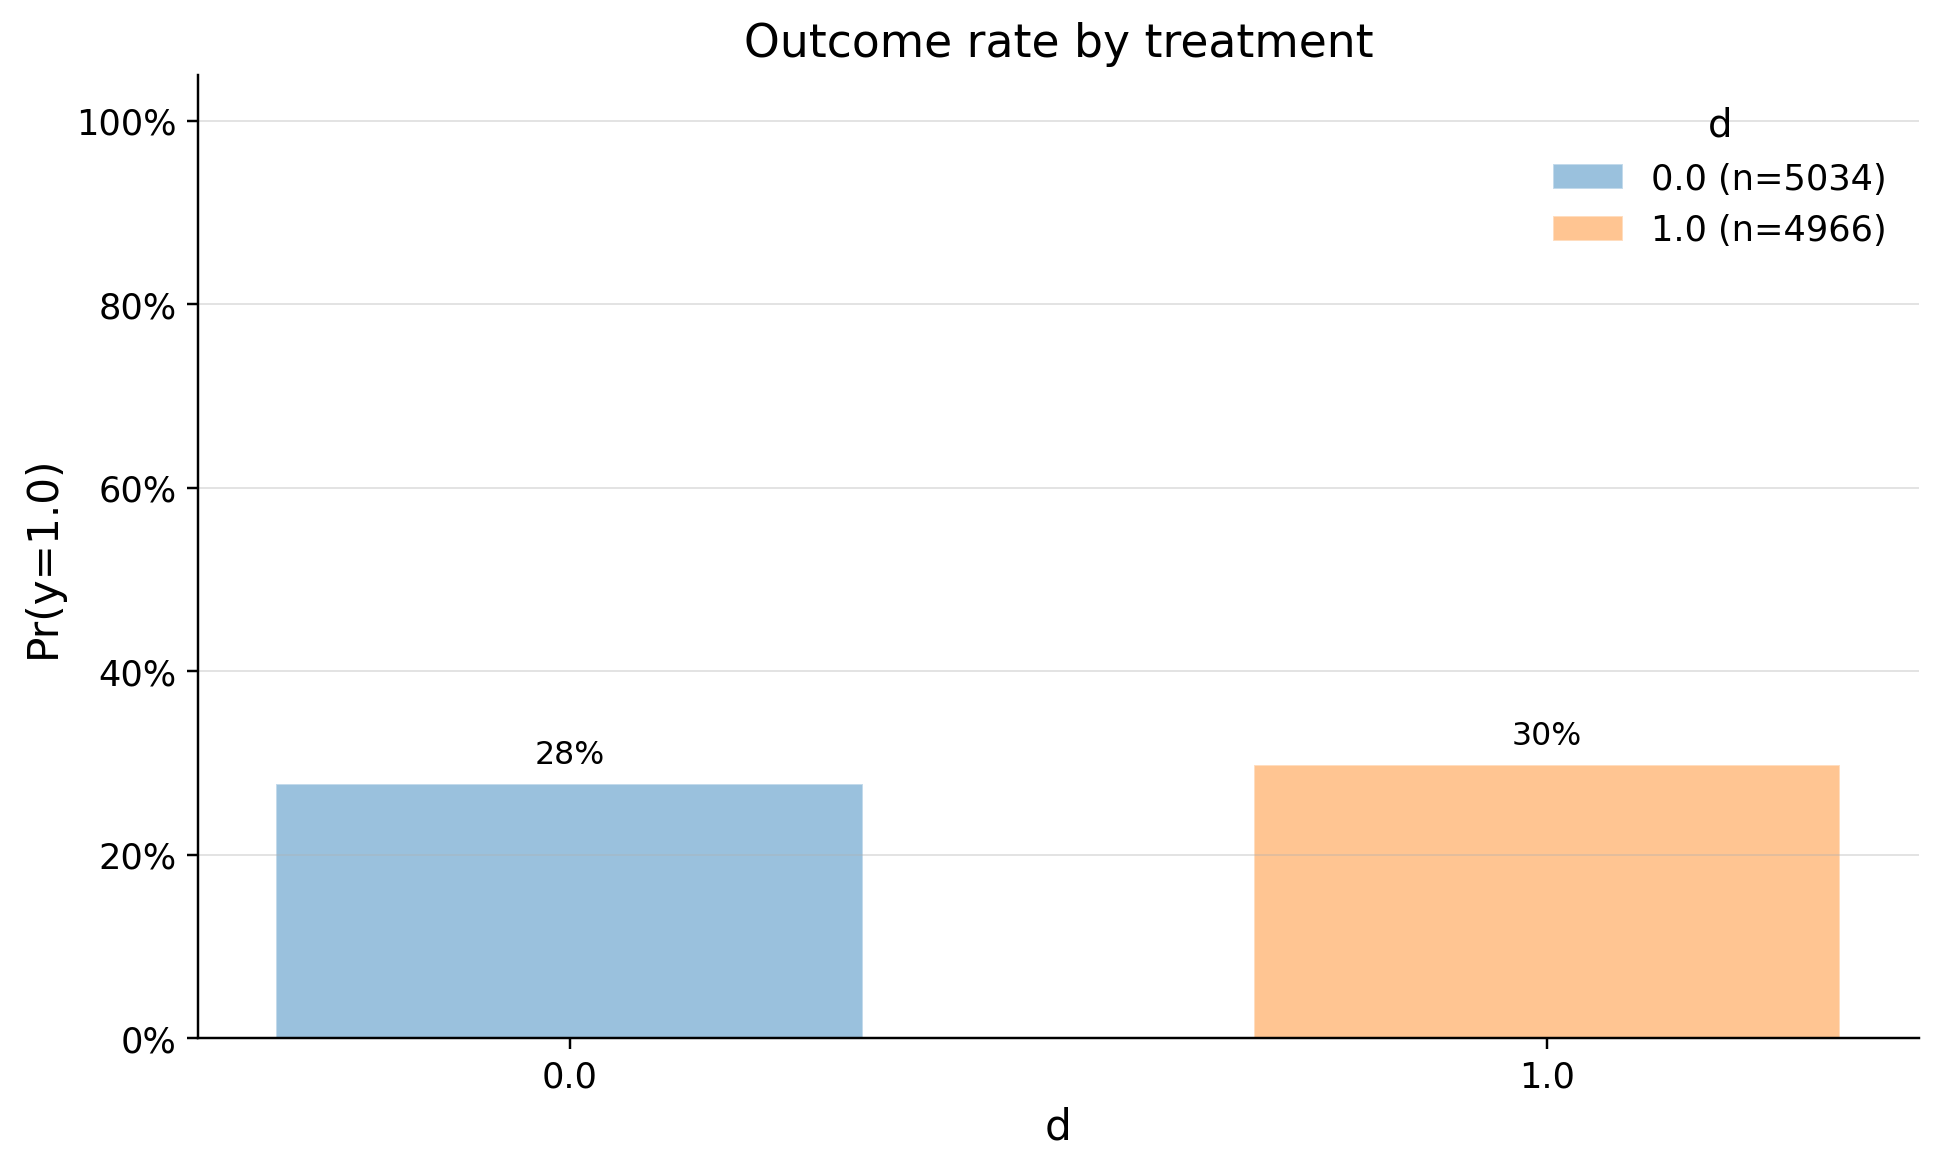

In [4]:
from causalis.shared import outcome_plot_dist, outcome_plot_boxplot
outcome_plot_dist(causaldata)

So we see that new section has higher conversion rate. Let's check if it is statistically significant and our test holds the indentification assumptions

# Monitoring of the split

In [5]:
from causalis.shared import check_srm

check_srm(assignments=causaldata, target_allocation={0: 0.5, 1: 0.5}, alpha=0.001)

SRMResult(status=no SRM, p_value=0.49650, chi2=0.4624)

In [6]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,region_eu,0.210369,0.189086,0.021284,-0.053250,0.20331
1,spend_last_month,77.921167,75.111595,2.809573,-0.039381,0.68313
2,plan_tier_pro,0.151569,0.161095,0.009526,0.026230,0.97481
3,support_tickets,1.817839,1.789569,0.028270,-0.020930,0.72761
4,referral_count,0.797378,0.785139,0.012239,-0.013696,1.00000
5,tenure_months,13.780500,13.732216,0.048284,-0.006523,0.69284
6,plan_tier_plus,0.298967,0.296214,0.002753,-0.006020,1.00000
7,discount_rate,0.100375,0.100514,0.000139,0.002123,0.34966
8,y_pre,-0.000064,0.000065,0.000129,0.000612,0.64056
9,email_open_rate,0.447786,0.447805,0.000020,0.000155,0.95826


There is no evidence of breaking unconfoundedness assumption

# Inference

We will use the `CUPEDModel` that implements the Lin (2013) "interacted adjustment" for ATE (Average Treatment Effect) estimation in randomized controlled trials (RCTs). This method is a robust version of ANCOVA that remains valid even when the treatment effect is heterogeneous with respect to the covariates.


#### 1. Specification
The model fits an Ordinary Least Squares (OLS) regression of the outcome $Y$ on the treatment indicator $D$ and centered pre-treatment covariates $X^c$. The specification includes full interactions between the treatment and the centered covariates:

$$Y_i = \alpha + \tau D_i + \beta^T X_i^c + \gamma^T (D_i \cdot X_i^c) + \epsilon_i$$

Where:
- $Y_i$: Outcome for individual $i$.
- $D_i$: Binary treatment indicator ($D_i \in \{0, 1\}$).
- $X_i$: Vector of pre-treatment covariates.
- $X_i^c = X_i - \bar{X}$: Centered covariates (where $\bar{X}$ is the sample mean).
- $\alpha$: Intercept (represents the mean outcome of the control group when $X = \bar{X}$).
- $\tau$: **Average Treatment Effect (ATE)** or Intent-to-Treat (ITT) effect.
- $\beta$: Vector of coefficients for the main effects of the covariates.
- $\gamma$: Vector of coefficients for the interaction terms between treatment and covariates.
- $\epsilon_i$: Residual error term.

In [7]:
from causalis.scenarios.cuped.model import CUPEDModel

model = CUPEDModel().fit(causaldata, covariates=['y_pre'])

In [8]:
result = model.estimate()
result.summary()

,value
field,
estimand,ATE
model,CUPEDModel
value,"0.0210 (ci_abs: 0.0054, 0.0365)"
value_relative,"7.5747 (ci_rel: 1.9572, 13.1923)"
alpha,0.0500
p_value,0.0081
is_significant,True
n_treated,4966
n_control,5034


Our result is significant with relative ci 7.5747% (ci_rel: 1.9572%, 13.1923%)

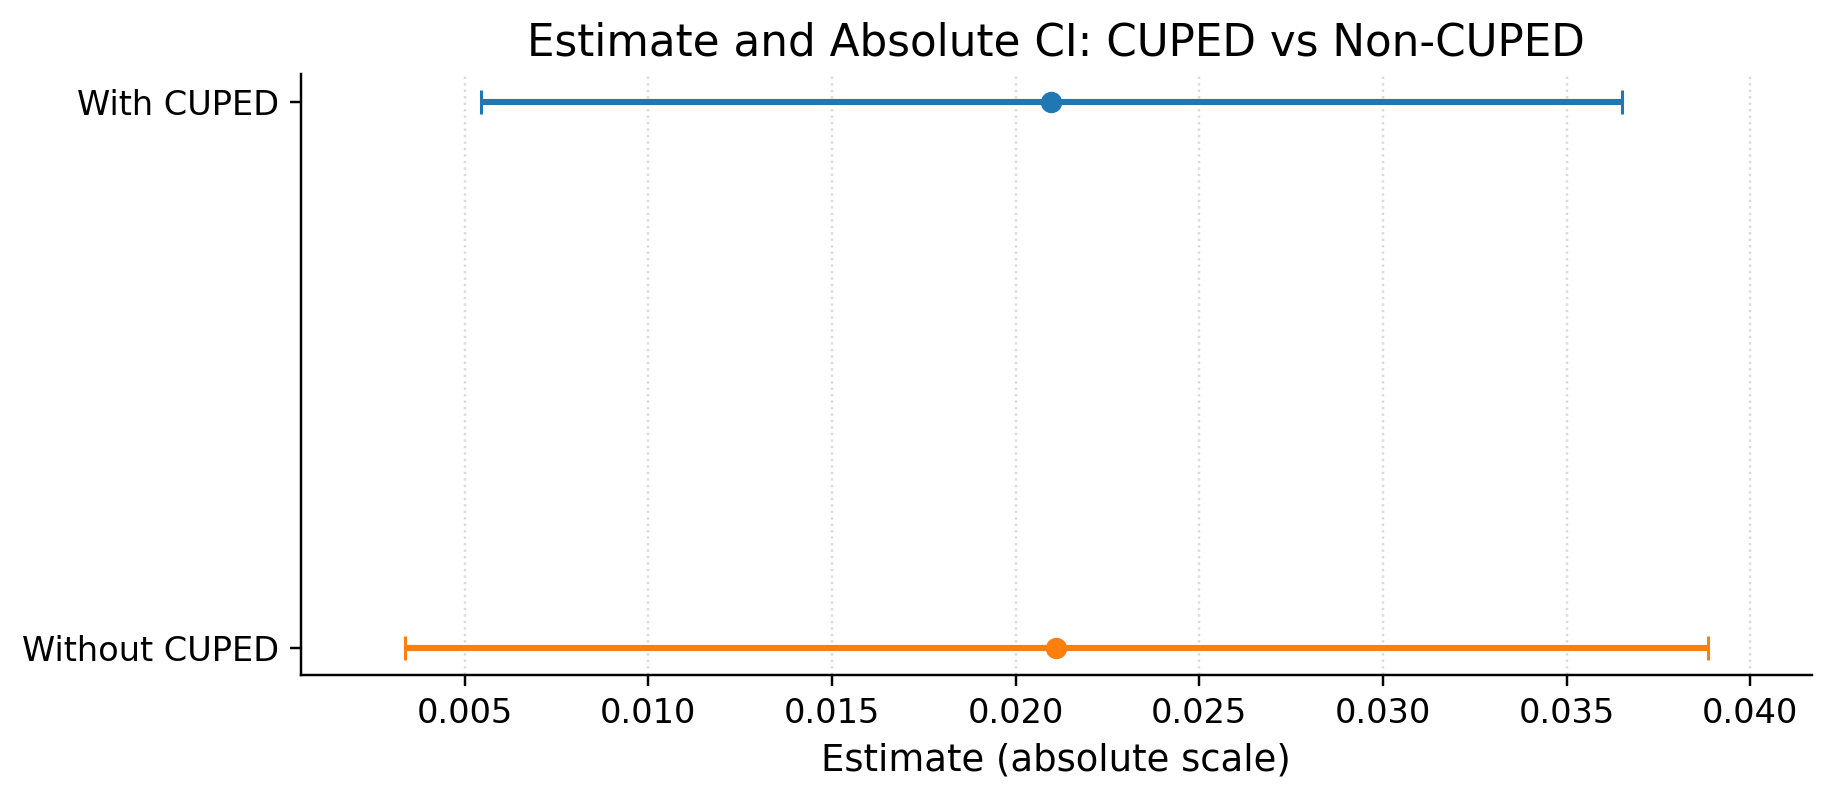

In [9]:
from causalis.scenarios.cuped import cuped_forest_plot
cuped_forest_plot(result)

In [11]:
print("var reduction by CUPED %:", result.diagnostic_data.se_reduction_pct_same_cov)

var reduction by CUPED %: 23.382355917736007


CUPED is worked. We reduced variance

# Let's check other assuptions

## SUTVA

In [12]:
from causalis.shared import print_sutva_questions
print_sutva_questions()

1.) Are your clients independent (i). Outcome of ones do not depend on others?
2.) Are all clients have full window to measure metrics?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


1. We assume that there is no networking effect
2. Metrics are valid
3. Confounders and covariates meseared before the treatment and outcome after
4. Lebeling treatment are consistent based of our logging system

## Overlap

Overlap is true by design

## Regression specification

In [13]:
from causalis.scenarios.cuped.diagnostics import (
    regression_assumptions_table_from_estimate,
    style_regression_assumptions_table,
)

assumptions_table = regression_assumptions_table_from_estimate(
    result,
    style_regression_assumptions_table=style_regression_assumptions_table,
)
assumptions_table

,test_id,test,flag,value,threshold,message
0,design_rank,Design rank,GREEN,"rank=4, k=4",rank == k,Design matrix is full rank.
1,condition_number,Condition number,GREEN,12.310161,<= 1.000e+08,Condition number is within expected range.
2,near_duplicates,Near-duplicate covariates,GREEN,0,0 pairs,No near-duplicate centered covariates found.
3,vif,Variance inflation factor,GREEN,nan,<= 20,VIF not applicable (fewer than two usable covariates).
4,ate_gap,Adjusted vs naive ATE,GREEN,0.014799,"yellow: > 2.00, red: > 2.50",Adjusted and naive ATE are reasonably aligned.
5,residual_tails,Residual extremes,GREEN,max|std resid|=2.53,"yellow > 7, red > 10",Residual extremes look reasonable.
6,leverage,Leverage,GREEN,"max_h=0.002482, n_high=787","yellow if max_h > 5*0.0008, red if max_h > max(0.5, 10*0.0008)",No high-leverage concentration detected.
7,cooks,Cook's distance,GREEN,"max=0.003232, n_high=434","yellow if max Cook's > 0.1, red if > 1",No strong influence signal from Cook's distance.
8,hc23_stability,HC2/HC3 stability,GREEN,"min(1-h)=9.975e-01, n_tiny=0",min(1-h) >= 1.0e-06,HC2/HC3 stability check passed.
9,winsor_sensitivity,Winsor sensitivity,GREEN,0.000000,"yellow: > 1.00 SE, red: > 2.00 SE",Winsorized refit is close to baseline ATE.


Our regression specification is valid

# In conclution

The new section is performing better than the older. Effect is "0.0210 (ci_abs: 0.0054, 0.0365)" in p.p. Roll out to all users